In [62]:
pip install statsmodels

     |████████████████████████████████| 9.4 MB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 83.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.stats import t
print(torch.cuda.device_count())
print(os.getcwd())
import statsmodels

1
/home/VM-Nicolas-Lafon/Danube


In [4]:
ncfile = Dataset('ResDanube4DVar/-exp3/model_Debit_KL-epoch=20-val_loss=0.29_res.nc')
ncfile_noKL = Dataset('ResDanube4DVar/-exp3/model_Debit-epoch=33-val_loss=0.28_res.nc')
#ncfile = Dataset('ResDanube4DVar/-exp2/model_Debit-epoch=06-val_loss=0.24-v1_res.nc')
flagprocess=4 #random maxk

In [6]:
debit_gt = ncfile['debit_gt']
debit_obs = ncfile['debit_obs']
debit_rec = ncfile['debit_rec']
debit_rec_noKL = ncfile_noKL['debit_rec']
print(debit_rec.shape)
print(debit_obs[0,:,:])

(874, 31, 12)
[[814.   792.   738.   713.   735.   744.   751.   754.   758.     0.
    0.     0.  ]
 [434.   414.   404.   388.   382.   388.   401.   421.   437.     0.
    0.     0.  ]
 [306.   299.   287.   278.   272.   278.   291.   308.   316.     0.
    0.     0.  ]
 [286.   278.   267.   259.   267.   276.   294.   309.   305.     0.
    0.     0.  ]
 [218.   216.   204.   198.   200.   207.   222.   235.   235.     0.
    0.     0.  ]
 [201.   194.   182.   180.   184.   196.   209.   222.   217.     0.
    0.     0.  ]
 [176.   171.   162.   160.   160.   173.   187.   196.   189.     0.
    0.     0.  ]
 [125.   121.   117.   114.   117.   120.   134.   141.   135.     0.
    0.     0.  ]
 [101.    95.6   94.4   94.3  101.   105.   110.   112.   106.     0.
    0.     0.  ]
 [ 73.8   71.8   70.    68.2   72.8   77.    81.1   82.2   78.     0.
    0.     0.  ]
 [ 15.4   14.    14.1   15.4   15.4   15.8   15.8   14.4   15.1    0.
    0.     0.  ]
 [  7.46   7.46   7.15   7.13

# Reconstruction


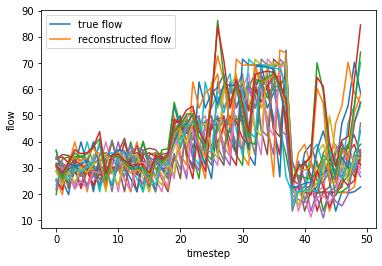

In [6]:
station = 21
plt.figure(0)
plt.plot(debit_gt[0:50,station])
plt.plot(debit_rec[0:50,station])
plt.xlabel('timestep')
plt.ylabel('flow')
plt.legend(['true flow', 'reconstructed flow'])

if flagprocess ==3 : 
    print(np.sum(debit_obs[0,:]==0))
    L1=[]
    L2=[]
    for i in range(506):
        if debit_obs[i,station]==0:
            L1.append(i)
        else : 
            L2.append(i)
    plt.figure(1)
    D=debit_gt[:,station]
    Drec=debit_rec[:,station]
    print(D[L1])
    plt.plot(D[L1])
    plt.plot(Drec[L1])
    plt.xlabel('timestep')
    plt.ylabel('flow')
    plt.legend(['true flow', 'reconstructed flow'])
    plt.figure(2)
    plt.plot(debit_gt[L2,station])
    plt.plot(debit_rec[L2,station])
    plt.xlabel('timestep')
    plt.ylabel('flow')
    plt.legend(['true flow', 'reconstructed flow'])

0.3377296018463616
21.144141638118935
[ 82.1  93.2  96.  107.  109.  115.  121.  125.  125. ]
[ 44  44  44 ... 494 494 494]
0.2323253976365733
35.245541599355136
77.63642951251647


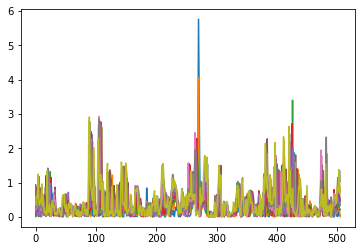

In [18]:
plt.plot(abs(debit_gt[:,station]-debit_rec[:,station])/debit_gt[:,station])
print(np.mean(abs(debit_gt[:,station]-debit_rec[:,station])/debit_gt[:,station]))
print(np.mean(abs(debit_gt[:,station]-debit_rec[:,station])))
debtrue = debit_gt[:,station]
debtrue.sort()
seuil = debtrue[455]
print(seuil)
ind= np.where(debit_gt[:,station]>seuil)
print(ind[0])
print(np.mean(abs(debit_gt[ind[0],station]-debit_rec[ind[0],station])/debit_gt[ind[0],station]))
print(np.mean(abs(debit_gt[ind[0],station]-debit_rec[ind[0],station])))
print(np.mean(debit_gt[:,station]))

In [6]:
index_sort_gt = np.argsort(debit_gt[:,station])
plt.scatter(debit_gt[index_sort_gt[450:506],station],debit_rec[index_sort_gt[450:506],station])
plt.plot(debit_gt[index_sort_gt[450:506],station],debit_gt[index_sort_gt[450:506],station])
plt.figure()
plt.scatter(debit_gt[index_sort_gt,station],debit_rec[index_sort_gt,station])
plt.plot(debit_gt[index_sort_gt,station],debit_gt[index_sort_gt,station])

IndexError: Index cannot be multidimensional

In [7]:
# Critère non-paramétrique de KL pour les extrêmes

Nn_gt = np.sum(debit_gt[:,station]>seuil)
print(Nn_gt)

Nn_rec = np.sum(debit_rec[:,station]>seuil)
print(Nn_rec)

def G_thilde(u,Y):
    l=len(Y)
    return (1-np.sum(Y<=u)/(l+1))

print(G_thilde(seuil,debit_gt[:,station]))

def L_hat(u,Y,X):
    Nn = np.sum(X>u)
    res=0
    for k in X:
        res+=(1/Nn)*np.log(G_thilde(max(k,u),Y)/G_thilde(u,Y))
        
    return(1+res)
                         
print(L_hat(seuil,debit_rec[:,station],debit_gt[:,station]))
print(L_hat(seuil,debit_gt[:,station],debit_rec[:,station]))

def K_hat(u,Y,X):
    return(-L_hat(u,Y,X)-L_hat(u,X,Y))

1049
959
-5.913214990138067


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [58]:
ncfile2 = Dataset('Dataset_danube.nc',"r")

NbDays          = 18244

In [8]:
L=[]
for i in range(31):
    L.append(ncfile2['S'+str(i+1)][:].reshape(18244,1))
        
dataset = np.concatenate((L[0],L[1],L[2],L[3],L[4],L[5],L[6],L[7],L[8],L[9],L[10],L[11],L[12],L[13],L[14],L[15],L[16],L[17],L[18],L[19],L[20],L[21],L[22],L[23],L[24],L[25],L[26],L[27],L[28],L[29],L[30]),axis=1)

# Definiton of training, validation and test dataset    
i=0
Indtrain=[]
Indval=[]
Indtest=[]
while (i+1)*395<(NbDays-1):
    x=395*i
    Indtrain.append([x,(x+305)])
    Indval.append([(x+319),(x+350)])
    Indtest.append([x+364,x+395])
    i+=1
    


NameError: name 'ncfile2' is not defined

In [49]:
print(Indtrain)
D=dataset[Indtrain[0][0]:Indtrain[0][1],3]
print(D)
for k in Indtrain[1::]:
    D=np.concatenate((D,dataset[k[0]:k[1],3]),axis=0)
print(len(D))

r=0.1
D.sort()
print(D[:10])
seuil=D[int((1-r)*len(D))]
print(seuil)

[[0, 305], [395, 700], [790, 1095], [1185, 1490], [1580, 1885], [1975, 2280], [2370, 2675], [2765, 3070], [3160, 3465], [3555, 3860], [3950, 4255], [4345, 4650], [4740, 5045], [5135, 5440], [5530, 5835], [5925, 6230], [6320, 6625], [6715, 7020], [7110, 7415], [7505, 7810], [7900, 8205], [8295, 8600], [8690, 8995], [9085, 9390], [9480, 9785], [9875, 10180], [10270, 10575], [10665, 10970], [11060, 11365], [11455, 11760], [11850, 12155], [12245, 12550], [12640, 12945], [13035, 13340], [13430, 13735], [13825, 14130], [14220, 14525], [14615, 14920], [15010, 15315], [15405, 15710], [15800, 16105], [16195, 16500], [16590, 16895], [16985, 17290], [17380, 17685], [17775, 18080]]
[419. 385. 366. 352. 419. 437. 400. 406. 417. 402. 324. 294. 280. 265.
 245. 242. 240. 238. 245. 260. 264. 264. 285. 313. 276. 267. 301. 305.
 316. 342. 360. 330. 309. 292. 289. 289. 285. 271. 235. 219. 242. 255.
 240. 243. 253. 227. 225. 228. 233. 248. 264. 299. 289. 298. 307. 342.
 391. 531. 702. 743. 735. 705. 718. 7

In [35]:
X1=np.random.randn(500)
print(max(X1))
Y1=np.random.randn(500)
print(max(Y1))
print(np.sum(X1>1))
print(np.sum(Y1>1))
print(G_thilde(3,Y1))
print(L_hat(3,X1,Y1))
print(L_hat(3,Y1,X1))
print(K_hat(3,X1,Y1))

4.477390750750359
3.0822163450876143
76
82
0.005988023952095856
1.0
-0.09861228866809113
-0.9013877113319089


In [54]:
#Risque Juliette

epsilon =0.5
g =(debit_rec[:,station]>seuil)
H = (debit_gt[:,station]>seuil)
g_eps = (debit_rec[:,station]>epsilon*seuil)
H_eps = (debit_gt[:,station]>epsilon*seuil)

compt1 = np.sum((g ^ H) &H_eps &g_eps)
print(compt1)
compt2 = np.sum((g | H) &H_eps &g_eps)
print(compt2)
R_juliette = compt1/compt2
print(R_juliette)

7
54
0.12962962962962962


# Prevision

### Premiers résultats

(874, 31, 12)


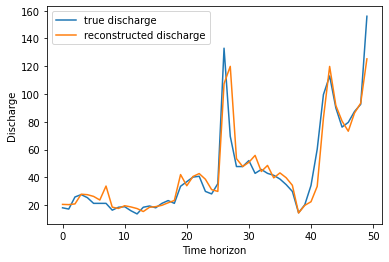

In [18]:
print(debit_gt[:].shape)

station = 24
Day = 9
# Comparaison GT et rec pour un élément donné du test
plt.plot(debit_gt[0:50,station,Day])
plt.plot(debit_rec[0:50,station,Day])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'reconstructed discharge'])

In [19]:
#Erreur relative en fonction du jour par station
D=abs(debit_gt[:,:,:]-debit_rec[:,:,:])/debit_gt[:,:,:]
print(D.shape)
# Erreur relative moyenne en fonction du jour et de la station
M = np.mean(D,0)
print(M[0,:])
#Erreur relative moyenne en fonction du jour
M2 =np.mean(M,0)
print(M2)



(874, 31, 12)
[0.03068432601549269 0.018615450444719878 0.03522801373937817
 0.023400121536736457 0.024983367934945155 0.02591502011411102
 0.021682581018402515 0.019365150068944247 0.013336300312403297
 0.058236234685517405 0.1028227291779745 0.14072176991367527]
[0.04472760834906715 0.038959714893402615 0.06311781841871004
 0.0458711748673448 0.04326342653223246 0.04499567358117017
 0.038498835838113206 0.03631881842912968 0.026757838644241194
 0.10598605857313091 0.17806288231664258 0.23098126594749535]


[1485.6037376   672.00171625  483.83352403  471.21081236  375.09439359
  352.07923341  331.81136537  201.96043097  168.3620328   127.86008772
   50.75906846   23.33553776  777.76868802  182.26284325  170.61363463
   72.14866514   53.43804348   31.10415713   23.71159039  124.6609077
   87.81117468   79.25367086   50.96863082   38.47544432   39.47577994
   36.68408848   27.17264397   44.91092582   40.77937262  268.7981598
  254.40860984]
[0.40751323 0.43419056 0.4460457  0.41400607 0.4356324  0.40988038
 0.43256025 0.4140584  0.42991232 0.41870046 0.3802504  0.35392015]


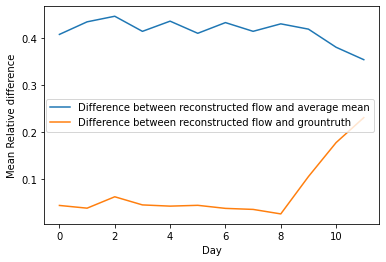

In [20]:
#Ecart entre les valeurs prédites au jour J et la valeur moyenne :
moy = np.mean(debit_gt[:,:,:],0)
moy2 = np.mean(moy,1)
print(moy2)
Ecart = np.zeros(debit_rec.shape)
for i in range(31):
    Ecart[:,i,:] =abs(debit_rec[:,i,:]-moy2[i])/moy2[i]
MoyEcart = np.mean(np.mean(Ecart,0),0)
print(MoyEcart)
plt.plot(MoyEcart)
plt.plot(M2)
plt.xlabel('Day')
plt.ylabel('Mean Relative difference')
plt.legend(['Difference between reconstructed flow and average mean', 'Difference between reconstructed flow and grountruth'])

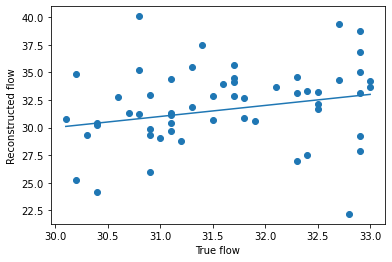

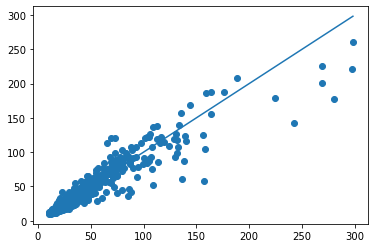

In [22]:
#qqplot extreme pour une station donnée en un jour de prévision donnée
station = 24
Day = 9
index_sort_gt = np.argsort(debit_gt[:,station,Day])
plt.scatter(debit_gt[index_sort_gt[450:506],station,Day],debit_rec[index_sort_gt[450:506],station,Day])
plt.plot(debit_gt[index_sort_gt[450:506],station,Day],debit_gt[index_sort_gt[450:506],station,Day])
plt.xlabel('True flow')
plt.ylabel('Reconstructed flow')
plt.figure()
plt.scatter(debit_gt[index_sort_gt,station,Day],debit_rec[index_sort_gt,station,Day])
plt.plot(debit_gt[index_sort_gt,station,Day],debit_gt[index_sort_gt,station,Day])

31.5
[ 19  20  21  22  25  26  27  28  29  30  31  32  33  34  35  36  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  57  58  62  65  66  67
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  96  97  98  99 100 101 103 104 107 108 109 110 111 114 118 119 138
 139 140 144 145 146 148 149 150 167 168 171 172 173 174 175 176 177 178
 179 208 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 285 286 287 288 289 290 291
 292 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 331 333 341 342 343 344
 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362
 363 364 365 366 367 368 369 370 371 373 374 375 376 377 378 379 447 448
 449 450 456 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472
 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 5

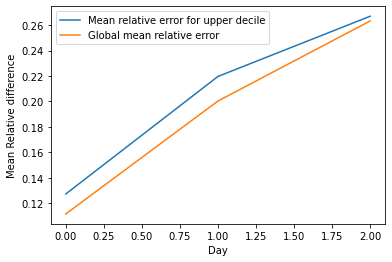

In [23]:
station=24
Day=9
debtrue = debit_gt[:,station,Day]
debtrue.sort()
seuil = debtrue[477]
print(seuil)
ind= np.where(debit_gt[:,station,Day]>seuil)
print(ind[0])
print(np.mean(abs(debit_gt[ind[0],station,Day]-debit_rec[ind[0],station,Day])/debit_gt[ind[0],station,Day]))
print(np.mean(abs(debit_gt[:,station,Day]-debit_rec[:,station,Day])/debit_gt[:,station,Day]))
print(np.mean(abs(debit_gt[ind[0],station,Day]-debit_rec[ind[0],station,Day])))
print(np.mean(abs(debit_gt[:,station,Day]-debit_rec[:,station,Day])))
print(np.mean(debit_gt[:,station]))
MRE_extreme = []
MRE=[]
for i in range(9,12):
    MRE.append(np.mean(abs(debit_gt[:,station,i]-debit_rec[:,station,i])/debit_gt[:,station,i]))
    debtrue = debit_gt[:,station,i]
    debtrue.sort()
    print(debit_gt[:50,station,i])
    seuil = debtrue[477]
    ind = np.where(debit_gt[:,station,i]>seuil)
    MRE_extreme.append(np.mean(abs(debit_gt[ind[0],station,i]-debit_rec[ind[0],station,i])/debit_gt[ind[0],station,i]))
    
    
print(MRE_extreme)
print(MRE)

plt.figure()
plt.plot(MRE_extreme)
plt.plot(MRE)
plt.xlabel('Day')
plt.ylabel('Mean Relative difference')
plt.legend(['Mean relative error for upper decile', 'Global mean relative error'])


### Comparaisons entre prévisions et persistance pour le jour 1

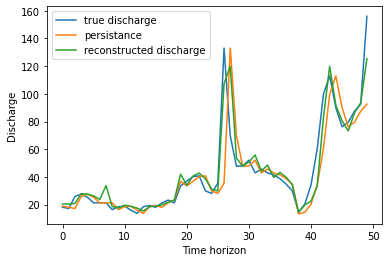

In [25]:
Day=9

debit_rec_true=debit_rec[:,:,Day]
debit_persistant = debit_gt[:,:,Day-1]
#debit_persistant = debit_rec[:,:,Day-1]
station = 24
# Comparaison GT et rec pour un élément donné du test
plt.plot(debit_gt[0:50,station,Day])
plt.plot(debit_persistant[0:50,station])
plt.plot(debit_rec_true[0:50,station])
plt.xlabel('Time horizon')
plt.ylabel('Discharge')
plt.legend(['true discharge', 'persistance','reconstructed discharge'])


In [10]:
#Erreur relative par station
D=abs(debit_gt[:,:,Day]-debit_rec_true[:,:])/debit_gt[:,:,Day]
print(D.shape)
# Erreur relative moyenne en fonction du jour et de la station
M = np.mean(D,0)
print(M.shape)
print(M[:])
#Erreur relative moyenne en fonction du jour
M2 =np.mean(M,0)
print(M2)

#Avec persistance
#Erreur relative en fonction du jour par station
D=abs(debit_gt[:,:,Day]-debit_persistant[:,:])/debit_gt[:,:,Day]
print(D.shape)
# Erreur relative moyenne en fonction du jour et de la station
M = np.mean(D,0)
print(M[:])
#Erreur relative moyenne en fonction du jour
M2 =np.mean(M,0)
print(M2)


(874, 31)
(31,)
[0.058236234685517405 0.0440057430810694 0.047965281640075214
 0.06817733879229794 0.05844025169780239 0.056941292883203196
 0.0674348021993684 0.08379701942893993 0.08904874856052221
 0.09434047992116477 0.17234148564701168 0.1753289589365359
 0.07483785468272316 0.05881463477615758 0.07312795209245014
 0.13890245093681472 0.11590259490065544 0.1289330385417494
 0.15160587361392497 0.08857951579705915 0.11461899915264395
 0.18041968630183264 0.09971146977619244 0.12245350190799995
 0.11156643273491018 0.12709548134788354 0.15071923469961443
 0.14933537697001611 0.15367849884682014 0.11149167889738171
 0.11771590231672055]
0.10598605857313094
(874, 31)
[0.06466677194038796 0.06394539968172927 0.07260393756008171
 0.08481857502708 0.07818124529413022 0.07839678202515715
 0.08424681281622003 0.09442421035317297 0.09793793812848976
 0.10564122882296102 0.1650800871687169 0.15161901488495214
 0.07583928112960249 0.07168147905384804 0.08058587692626018
 0.14676710898135242 0

In [17]:
# Variance 
D_rec=(debit_gt[:,:,Day]-debit_rec_true[:,:])**2
#Variance par station
M_rec = np.mean(D_rec,0)
print(M_rec)


D_persistant = (debit_gt[:,:,Day]-debit_persistant[:,:])**2
#Variance par station
M_persistant = np.mean(D_persistant,0)
print(M_persistant)

V_exp = M_rec/M_persistant
print("Variance expliquée")
print(1-V_exp)
print(np.where(V_exp<0.6))
print(1-np.mean(V_exp))


[28712.14361076  2687.14714989  1994.92305883  3150.01987355
  1541.65496024  1255.97415109  1760.86043335  1047.91491565
   985.60878988   587.57910609   429.43309825    88.95805853
 16218.33247828   275.41859616   369.33738353   348.1374577
   166.84436691   107.09330246    95.74080665   540.77514312
   356.12426118   392.28241431   103.37580622    87.76218862
   131.74855888   173.10118343   158.28962301   253.73034804
   250.18761126  4863.33375254  4153.23112627]
[31362.83180778  5756.73798627  4243.97482838  4818.39702517
  2884.66475973  2565.9187643   2733.62929062  1314.31124714
  1199.12827231   805.623627     474.89496568    91.49858295
 17169.25400458   490.88786041   508.71718535   473.29016018
   217.29240275   121.85018993    97.67208787   766.62162471
   388.1026659    376.18332952   140.30797483   135.95140767
   317.09203661   336.41994554   181.6150397    258.72924783
   260.3445762   5594.60718535  4398.05418764]
Variance expliquée
[0.08451686420624482 0.53321704821

#### Récapitulatif des résultats pour différentes configurations


<table>
<caption style="caption-side:bottom">Tableau des résultats</caption>
<tr>
<th>Configuration</th>
<th>Batch</th>
<th>Epoch</th>
<th>KL</th>
<th>MRE Day 1</th>
<th>MRE Day 2</th>
<th>MRE Day 3</th>
<th>Variance expliquée Day 1</th>
<th>Variance expliquée Day 2</th>
<th>Variance expliquée Day 3</th>
</tr>
<tr>
<td>1</td>
<td>96</td>
<td>31</td>    
<td>YES</td>
<td>10,3%</td>
<td>16,9%</td>
<td>21,1%</td>
<td>28,8%</td>
<td>23,5%</td>
<td>22,6%</td>
</tr>
<tr>
<td>2</td>
<td>96</td>
<td>33</td> 
<td>NO</td>
<td>12,0%</td>
<td>18,0%</td>
<td>22,2%</td>
<td>25,4%</td>
<td>23,9%</td>
<td>22,8%</td>
</tr>
</table>

# Critère KL pour les extrêmes

In [18]:
X1= t.rvs(2.5, size=10000)
print(max(X1))
Y1=t.rvs(1.5, size=10000)
print(max(Y1))
print(np.sum(X1>20))
print(np.sum(Y1>20))

76.10655561134253
339.9526694960497
6
38


In [14]:
from statsmodels.distributions.empirical_distribution import ECDF
l=len(Y1)
ecdf = ECDF(Y1)
def G_bar(x):
    return(1-ecdf(x))
print(np.where(Y1>1))

def L_hat_opti(u,Y,X):
    Ind = np.where(X>u)
    ecdf = ECDF(Y)
    l=len(Y)
    def G_thilde_opti(x):
        return(l/(l+1)*(1-ecdf(x))+1/(l+1))
    G_u= G_thilde_opti(u)
    A = np.log(G_thilde_opti(X[Ind])/G_u)
    res=np.sum(A)/len(Ind[0])+1
    return(res)


print(L_hat_opti(3,X1,Y1))    
x= np.linspace(-10,10,1000)
l=len(Y1)
plt.plot(x,l*G_bar(x)/(l+1)+1/(l+1))


NameError: name 'Y1' is not defined

In [20]:
# Critère non-paramétrique de KL pour les extrêmes


def G_thilde(u,Y):
    l=len(Y)
    return (1-np.sum(Y<=u)/(l+1))

def L_hat(u,Y,X):
    Nn = np.sum(X>u)
    res=0
    count=0
    for k in X:
        res+=(1/Nn)*np.log(G_thilde(max(k,u),Y)/G_thilde(u,Y)) 
        count+=1
    return(1+res)
                         

def K_hat(u,Y,X):
    return(-L_hat(u,Y,X)-L_hat(u,X,Y))


print(G_thilde(3,Y1))
print(K_hat(3,Y1,Y1))
#print(L_hat(3,X1,Y1))
print(K_hat(3,X1,Y1))


#Accélération du calcul de KL


def L_hat_opti(u,Y,X):
    Ind = np.where(X>u)
    if len(Ind[0])==0 :
        return(1)
    else : 
        ecdf = ECDF(Y)
        l=len(Y)
        def G_thilde_opti(x):
            return(l/(l+1)*(1-ecdf(x))+1/(l+1))
        G_u= G_thilde_opti(u)
        M= X[Ind]
        B= G_thilde_opti(M)/G_u
        A = np.log(B)
        res=np.sum(A)/len(Ind[0])+1 
        return(res)


def K_hat(u,Y,X):
    return(-L_hat_opti(u,Y,X)-L_hat_opti(u,X,Y))


def K_hat_tensor(seuil,X,Y):
    n=X.shape[0]
    res=0
    for i in range(n):
        resi=K_hat(seuil[i],X[i,:],Y[i,:])
        res+=resi
    return(res)

print(K_hat(3,X1,Y1))

0.07129287071292867
-0.008999427304635876
0.07415254524426362
0.07415254524427428


In [21]:
print(type(debit_gt[:]))
seuil_10 = [2220,  1020. ,  764.,   744. ,  577. ,  535.,   511.,   329.,   279. ,  218.,
   92.3 ,  45.,  1240.,   257. ,  250.,   116. ,   81.5,   46.7,   35.3,  179.,
  130.,   123.,    96.5,   78.6 ,  69.,    62.1,   47.6 ,  81.8,   74.4 , 449.,
  427. ]
print(seuil_10)
gt = debit_gt[:,:,Day]
print(gt.shape)
print(debit_rec_true.shape)
debit_rec_true_noKL = debit_rec_noKL[:,:,Day]
L_rec=[]
L_pers=[]
for k in range(31):
    L_rec.append(K_hat(seuil_10[k],gt[:,k],debit_rec_true[:,k])-min(K_hat(seuil_10[k],gt[:,k],gt[:,k]),K_hat(seuil_10[k],debit_rec_true[:,k],debit_rec_true[:,k])))
    #print(K_hat(seuil_10[k],gt[:,k],debit_rec_true[:,k]))
    #print(K_hat(seuil_10[k],gt[:,k],gt[:,k]))
    #print(K_hat(seuil_10[k],debit_rec_true[:,k],debit_rec_true[:,k]))
    L_pers.append(K_hat(seuil_10[k],gt[:,k],debit_rec_true_noKL[:,k])-min(K_hat(seuil_10[k],gt[:,k],gt[:,k]),K_hat(seuil_10[k],debit_rec_true_noKL[:,k],debit_rec_true_noKL[:,k])))
print(L_rec)
print(L_pers)


<class 'numpy.ma.core.MaskedArray'>
[2220, 1020.0, 764.0, 744.0, 577.0, 535.0, 511.0, 329.0, 279.0, 218.0, 92.3, 45.0, 1240.0, 257.0, 250.0, 116.0, 81.5, 46.7, 35.3, 179.0, 130.0, 123.0, 96.5, 78.6, 69.0, 62.1, 47.6, 81.8, 74.4, 449.0, 427.0]
(874, 31)
(874, 31)
[-0.02302401030486989, -0.0011063611087537284, -0.006609804268191244, -0.030246616579434615, -0.03657022310719038, -0.040039277587762934, -0.04135282754173797, -0.03947795005021848, -0.03758104944050278, -0.04326846037196208, -0.03312913958199726, -0.016383330297038312, -0.035467575385533245, -0.0462578517292106, -0.03318766994179834, -0.03698594410543088, -0.03233078772320508, -0.038959383609184384, -0.004603830335234593, -0.029650819274470108, -0.02160398936044461, -0.020537667373162205, -0.041435575239237576, -0.044297525758162815, -0.007779320066971129, -0.005027193633677762, 0.008491503784190724, -0.022764947285003, -0.023222039517982074, -0.030284842125884004, -0.022314618500957617]
[-0.033825426421304705, 0.0161014320130

### Paramètre de forme pour chaque station

In [28]:
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('POT') #installing POT package

R[write to console]: Installing package into ‘/home/VM-Nicolas-Lafon/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/POT_1.1-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1028906 bytes (1004 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f8e64a127c0> [RTYPES.NILSXP]

In [29]:
from thresholdmodeling import thresh_modeling as t#importing package
    
    

<table>
<caption style="caption-side:bottom">Paramètre de forme par station, seuil à 10%</caption>
<tr>
<th>Station</th>
<th>1</th>
<th>2</th>
<th>3</th>
<th>4</th>
<th>5</th>
<th>6</th>
<th>7</th>
<th>8</th>
<th>9</th>
<th>10</th>
<th>11</th>
<th>12</th>
<th>13</th>
<th>14</th>
<th>15</th>
<th>16</th>
<th>17</th>
<th>18</th>
<th>19</th>
<th>20</th>
<th>21</th>
<th>22</th>
<th>23</th>
<th>24</th>
<th>25</th>
<th>26</th>
<th>27</th>
<th>28</th>
<th>29</th>
<th>30</th>
<th>31</th>
</tr>
<tr>
<th>Shape</th>
<th>0.061</th>
<th>0.052</th>
<th>0.083</th>
<th>0.073</th>
<th>0.062</th>
<th>0.092</th>
<th>0.086</th>
<th>0.055</th>
<th>0.052</th>
<th>0.050</th>
<th>0.20</th>
<th>0.15</th>
<th>0.15</th>
<th>0.18</th>
<th>0.22</th>
<th>0.21</th>
<th>0.24</th>
<th>0.28</th>
<th>0.29</th>
<th>0.34</th>
<th>0.23</th>
<th>0.21</th>
<th>0.14</th>
<th>0.14</th>
<th>0.25</th>
<th>0.26</th>
<th>0.28</th>
<th>0.22</th>
<th>0.24</th>
<th>0.18</th>
<th>0.18</th>
</tr>
<tr>
<th>Standard Error</th>
<th>0.035</th>
<th>0.027</th>
<th>0.028</th>
<th>0.027</th>
<th>0.026</th>
<th>0.027</th>
<th>0.026</th>
<th>0.027</th>
<th>0.026</th>
<th>0.026</th>
<th>0.028</th>
<th>0.024</th>
<th>0.027</th>
<th>0.027</th>
<th>0.027</th>
<th>0.028</th>
<th>0.030</th>
<th>0.032</th>
<th>0.030</th>
<th>0.032</th>
<th>0.028</th>
<th>0.028</th>
<th>0.027</th>
<th>0.026</th>
<th>0.032</th>
<th>0.031</th>
<th>0.031</th>
<th>0.028</th>
<th>0.028</th>
<th>0.027</th>
<th>0.027</th>
</tr>
</table>

'nan'


## Distribution suivie par les erreurs

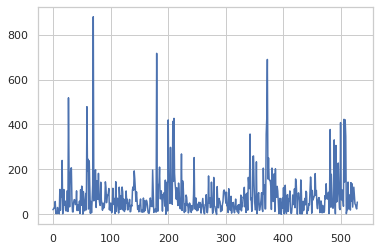

In [42]:
station =0
Day = 9
diff = debit_gt[:,station,Day]-debit_rec[:,station,Day]
ind_plus = np.where(diff>0)
ind_moins = np.where(diff<0)


plt.plot(np.abs(diff[ind_moins]))

In [12]:
from thresholdmodeling import thresh_modeling as t#importing package

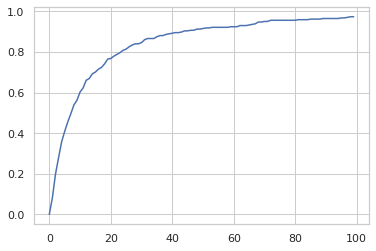

In [22]:
ecdf = ECDF(diff[ind_plus])
print(ECDF(diff[ind_plus]))
x=np.linspace(0,700,100)
plt.plot(ecdf(x),)

In [50]:
t.gpdfit(np.abs(diff[ind_moins]),100,'mle')

Estimator: MLE 
 Deviance: 1485.078 
      AIC: 1489.078 

Varying Threshold: FALSE 

  Threshold Call: 100L 
    Number Above: 137 
Proportion Above: 0.259 

Estimates
 scale   shape  
54.323   0.426  

Standard Error Type: observed 

Standard Errors
 scale   shape  
8.2504  0.1306  

Asymptotic Variance Covariance
       scale     shape   
scale  68.06888  -0.68598
shape  -0.68598   0.01705

Optimization Information
  Convergence: successful 
  Function Evaluations: 62 
  Gradient Evaluations: 32 




(0.42602639242528473,
 54.32287654165066,
 masked_array(data=[0.08688974992060139, 0.5997813942580024,
                    0.6673114869477104, 1.3776852966370825,
                    1.4599731864113892, 1.8690039878401876,
                    2.6511359001844994, 2.7044539105236254,
                    2.8390823649546064, 2.922419862537936,
                    2.9611066560603376, 2.985498324750097,
                    3.0691874250580895, 3.1775651852183273,
                    3.2392821566886596, 3.4082008748637236,
                    3.536408738799537, 3.6650636495660365,
                    3.9161317210775906, 4.160651939268064,
                    4.257343756094997, 4.323303156198563,
                    4.413727112586457, 4.902573186030736, 5.13360632750846,
                    5.202460579440867, 5.212455379899666, 5.3835266964943,
                    5.509419360287438, 5.8264263173166455,
                    5.866424091564568, 6.210892959302441,
                    6.3804749136440